In [1]:
import database_utils
import utils
DB_PATH = "products.db"

In [ ]:
database_utils.create_db(DB_PATH, n_employees=100, n_products=200, n_txns_per_product=200000)

SQLite database 'products.db' created with a 'transactions' table (event-sourced), 'products' table, and 'employees' table.


In [3]:
schema_text = database_utils.get_schema(DB_PATH)
utils.print_html(schema_text, f"Table Schemas in {DB_PATH}")

In [4]:
query = """
    select * from products where is_limited=1
    order by release_date asc
    limit 10
    """
results = database_utils.execute_sql(
    query=query,
    db_path=DB_PATH)
utils.print_html(results, query)

id,name,brand,category,color,is_limited,notes,release_date
13621,New Balance hoodie,New,Balance,green,1,None,1996-05-08 00:29:04.015877
3041,Puma hat,Puma,hat,white,1,None,1996-05-08 04:17:49.295583
2400,Nike shoes,Nike,shoes,cream,1,None,1996-05-09 02:35:41.856854
3702,New Balance cleats,New,Balance,cream,1,None,1996-05-10 00:13:30.637718
18635,Nike shoes,Nike,shoes,cream,1,None,1996-05-13 16:55:33.327807
1673,Adidas hoodie,Adidas,hoodie,black,1,None,1996-05-25 22:28:12.573292
15506,Adidas hat,Adidas,hat,cream,1,None,1996-06-12 02:26:26.025527
10816,Nike t-shirt,Nike,t-shirt,cream,1,None,1996-07-15 03:30:09.153391
4858,New Balance hoodie,New,Balance,white,1,None,1996-08-01 13:45:54.156363
4470,Reebok hat,Reebok,hat,black,1,None,1996-08-11 19:13:13.929752


Let's do an example of joining tables...

Which employee is responsible for releasing the most products?

In [5]:
query = """
    select employees.name, COUNT(transactions.id)
    from employees
    join transactions on employees.id=transactions.employee_id
    where transactions.action="insert"
    """
results = database_utils.execute_sql(
    query=query,
    db_path=DB_PATH)
utils.print_html(results, "Which employee is responsible for releasing the most products?")

name,COUNT(transactions.id)
Watanabe Deepti,20000


Because of how I've seeded the database, all insertions were credited to a single employee. This is not an ideal situation, but is not unlike what could occur in real databases.

Now let's investigate sales

_Who are the top performing employees in terms of sales?_

Note that, due to how the database is currently setup (and how the business is flattened), there is more than one valid way to answer this question.
1. Of all employees, who has accumulated the highest total sales
2. Of only employees in the sales organization, who has the highest total sales

In [6]:
query="""
    select employees.name, employees.department, SUM(-transactions.qty_delta * transactions.unit_price) as total_revenue
    from employees
    join transactions on employees.id=transactions.employee_id
    where transactions.action="sale"
    group by employees.name
    order by total_revenue desc
    limit 10;
    """
results = database_utils.execute_sql(
    query=query,
    db_path=DB_PATH)
utils.print_html(results, "Who are the top performing employees in terms of sales?")

name,department,total_revenue
Zephyr Ishi,stock,33575707.35
Bruno Charles,stock,27866743.04
Goodall Zephyr,corporate,27732996.49
Eileen Zephyr,sales,27695292.69
Watanabe Zephyr,fitting,22375524.88
Henrik Frederic,corporate,22316608.10
Deepti Watanabe,corporate,22261249.60
Ishi Henrik,sales,22227588.93
Abby Bruno,sales,22214214.90
Henrik Deepti,stock,22101406.61


_Who are the top performing employees in terms of sales this calendar year?_

In [10]:
query=f"""
    select employees.name, employees.department, MIN(transactions.ts) as first_transaction, SUM(-transactions.qty_delta * transactions.unit_price) as revenue
    from employees
    join transactions on employees.id=transactions.employee_id
    where transactions.action="sale" and transactions.ts>=date('now', 'start of year')
    group by employees.name
    order by revenue desc
    limit 10;
    """
results = database_utils.execute_sql(
    query=query,
    db_path=DB_PATH)
utils.print_html(results, "Who are the top performing employees in terms of sales this calendar year?")

name,department,first_transaction,revenue
Zephyr Ishi,fitting,2025-01-01 14:46:17.717911,33106485.59
Bruno Charles,corporate,2025-01-02 06:27:41.013032,27485036.42
Goodall Zephyr,stock,2025-01-01 00:38:08.045337,27383459.55
Eileen Zephyr,sales,2025-01-03 11:06:53.973756,27318895.14
Watanabe Zephyr,stock,2025-01-01 10:36:26.855133,22091844.73
Henrik Frederic,corporate,2025-01-04 11:30:10.383996,22007747.94
Deepti Watanabe,sales,2025-01-13 11:33:54.731040,21951003.34
Ishi Henrik,stock,2025-01-03 21:47:31.173702,21932373.66
Abby Bruno,sales,2025-01-06 23:48:26.724358,21925748.64
Henrik Deepti,stock,2025-01-03 23:13:17.886938,21795129.15


_What is the yearly revenue of the company?_

In [12]:
query=f"""
    select date(ts, 'start of year') as year, sum(-qty_delta * unit_price) as revenue
    from transactions
    where action="sale"
    group by date(ts, 'start of year')
    order by year
    """
results = database_utils.execute_sql(
    query=query,
    db_path=DB_PATH)
utils.print_html(results, "What is the yearly revenue of the company?")

year,revenue
1997-01-01,8.443800e+03
1998-01-01,2.068158e+04
1999-01-01,2.041787e+04
2000-01-01,2.900848e+04
2001-01-01,2.519552e+04
2002-01-01,4.528011e+04
2003-01-01,5.686782e+04
2004-01-01,7.980869e+04
2005-01-01,8.839197e+04
2006-01-01,9.628287e+04


<Axes: xlabel='company year', ylabel='Revenue in USD($)'>

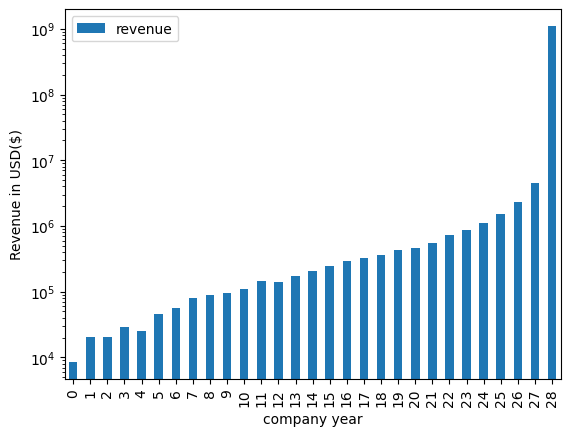

In [19]:
results.plot(kind="bar", logy=True, xlabel='company year', ylabel='Revenue in USD($)')

_How many products are released per year?_

In [22]:
query=f"""
    select date(release_date, 'start of year') as year, COUNT(id) as count_releases
    from products
    group by date(release_date, 'start of year')
    order by year
    """
results = database_utils.execute_sql(
    query=query,
    db_path=DB_PATH)
utils.print_html(results, "How many products are released per year?")

year,count_releases
1996-01-01,437
1997-01-01,640
1998-01-01,699
1999-01-01,658
2000-01-01,664
2001-01-01,715
2002-01-01,677
2003-01-01,683
2004-01-01,642
2005-01-01,687


<Axes: xlabel='company year', ylabel='Number of Product Releases'>

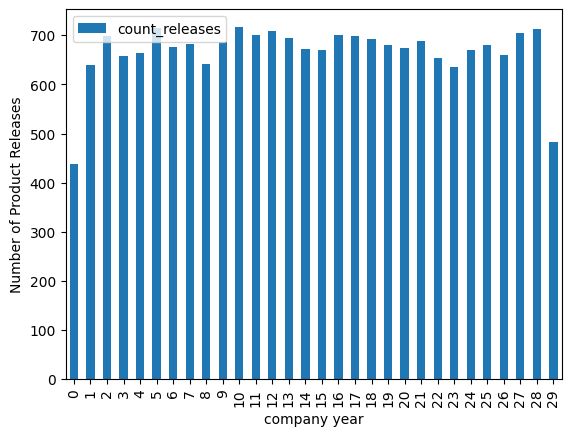

In [23]:
results.plot(
    kind="bar",
    xlabel='company year',
    ylabel='Number of Product Releases')

In [8]:
database_utils.execute_sql(
    query="select date('now', 'start of year')",
    db_path=DB_PATH)

,"date('now', 'start of year')"
0,2025-01-01
